# Linking observations of wind at the surface to winds aloft

Author: Daniel Hogan
Created: June 20, 2024

This notebook will start to address three main questions (with sub-focuses discussed below):
1) How do observations of wind speed at the surface compare to winds aloft in 2022 and 2023
2) How often are wind directions and magnitudes consistent? How often are they different?
3) How does the inversion depth and strength relate to these conditions?
4) How can we identify incoming storm systems? Humidity profiles?

### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


# Grabbing our data of interest

### First all the met data

In [24]:
# Kettle Ponds SOS Data
kp_sos_23 = xr.open_dataset('../../01_data/processed_data/sos_ds_1H_storage.nc')
kp_sos_max_23 = xr.open_dataset('../../01_data/processed_data/sos_ds_1H_max_wspd_storage.nc')

# Kettle Ponds SAIL Data 2022 + 2023
kp_sail_22 = xr.open_dataset('../../01_data/processed_data/sail_processed/sail_ds_1H_met_kp_2022.nc')
kp_sail_23 = xr.open_dataset('../../01_data/processed_data/sail_processed/sail_ds_1H_met_kp_2023.nc')

# Kettle Ponds SPLASH Data 2022
kp_splash_22 = xr.open_dataset('../../01_data/processed_data/splash/w22_splash_kp_qc_1H.nc')

# Gothic SAIL Data 2022 + 2023
gts_sail_22 = xr.open_dataset('../../01_data/processed_data/sail_processed/sail_ds_1H_met_2022.nc')
gts_sail_23 = xr.open_dataset('../../01_data/processed_data/sail_processed/sail_ds_1H_met_2023.nc')

# SPLASH Avery Picnic Data 2022 + 2023
ap_splash_22 = xr.open_dataset('../../01_data/processed_data/splash/w22_splash_ap_qc_1H.nc')
ap_splash_23 = xr.open_dataset('../../01_data/processed_data/splash/w23_splash_ap_qc_1H.nc')

# Now the radiosondes

In [3]:
files_22 = glob.glob('/storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/*')
files_23 = glob.glob('/storage/dlhogan/synoptic_sublimation/sail_data/winter_22_23/radiosonde/*')
# create a function to get specific soundin data
# we want to grab the values when pressure is closest to 700, 650, 600, 550, 500, 450, 400, 350, and 300 hPa
# We then want to calculate the time offset from the start time of the sounding and then combine this into a new dataset
# with coordinates of inital time, and pressure level
# and variables of temperature, dewpoint, wind speed, wind direction, rh, and height etc
def get_sounding_height_data(ds):
    # get the start time of the sounding
    start_time = pd.to_datetime(ds.time.values[0])
    # round to either 00Z or 12Z
    if (start_time.hour < 6) | (start_time.hour > 18):
        start_time = start_time.replace(hour=0, minute=0, second=0)
    else:
        start_time = start_time.replace(hour=12, minute=0, second=0)
    # get the time delta of every other measurement
    time_delta = ds.time.values - ds.time.values[0]
    # get the pressure levels we want
    pressure_levels = [700, 650, 600, 550, 500, 450, 400, 350, 300]
    # create a dictionary to hold the data
    data = {}
    # loop through the pressure levels
    for p in pressure_levels:
        # get the index of the pressure level
        idx = np.argmin(np.abs(ds.pres.values - p))
        # get the time offset convert to hours
        time_offset = time_delta[idx].astype('timedelta64[s]').astype('timedelta64[m]')
        # get the data
        data[p] = {'time_offset': time_offset,
                   'pressure': ds.pres.values[idx],
                   'tdry': ds.tdry.values[idx],
                   'dp': ds.dp.values[idx],
                   'u_wind': ds.u_wind.values[idx],
                   'v_wind': ds.v_wind.values[idx],
                   'wspd': ds.wspd.values[idx],
                   'deg': ds.deg.values[idx],
                   'rh': ds.rh.values[idx],
                   'alt': ds.alt.values[idx]}
    # create a dataframe
    df = pd.DataFrame(data).T
    # add the start time
    df['start_time'] = start_time

    # convert to xarray and make start_time and coordinate
    df = df.reset_index().rename(columns={'index': 'pres'})
    df['pres'] = df['pres'].astype('int')
    df = df.set_index(['start_time', 'pres'])

    return df

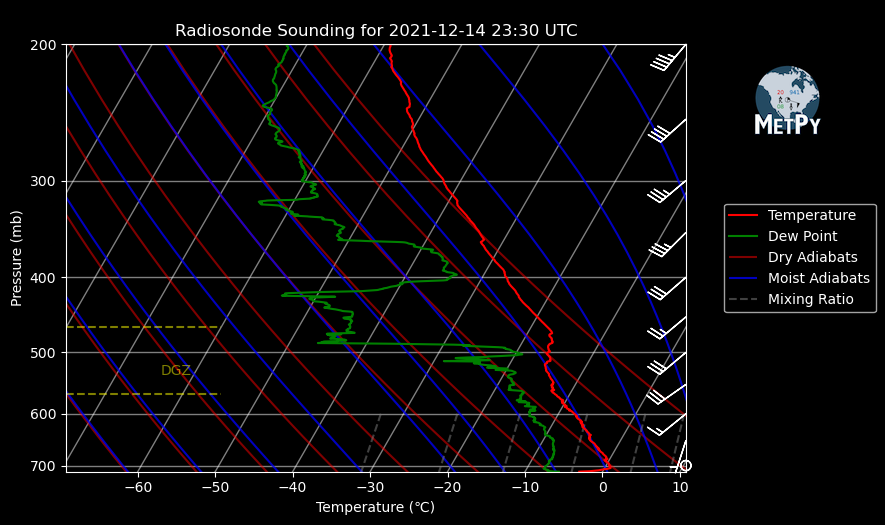

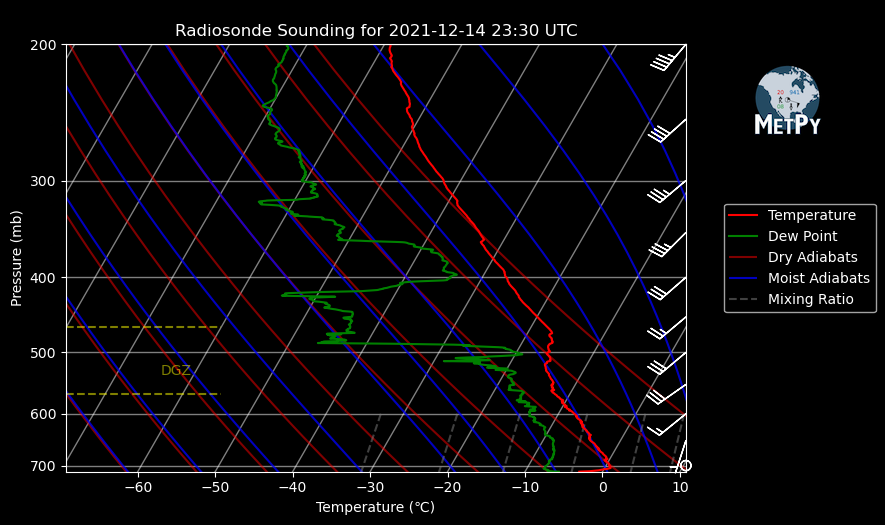

In [4]:
ds_a = xr.open_dataset(files_22[150])
simple_sounding(ds_a)

In [326]:
# create another function to calculate the inversion depth by first changing temperature to virtual potential temperature, and finding the height of the inversion between the surface
ds = xr.open_dataset(files_22[250])
from scipy.ndimage import gaussian_filter1d
def calculate_inversion_depth(ds):
    # group data by 1 hPa bins
    df = ds[['pres','tdry','alt']].to_dataframe().reset_index(drop=True)
    time = pd.to_datetime(ds.time.values[0])
    df['tdry'] = gaussian_filter1d(df.tdry, sigma=2)
    df = df.groupby(pd.cut(df.alt, np.arange(df.alt.min(),df.alt.max(),10))).mean().reset_index(drop=True)
    
    # calculate the inversion depth
    # lower tropospheric temperature inversions are characterized on the basis of their base height (Zbase), top height (Ztop), depth (deltaZ), and intensity (deltaT) using 
    # methods from Kahl (1990). Zbase in the first level where T startsto increase with height. The inversion is classified as surface based when Zbase is at ground level
    # and as a low level inversion when Z-base is elevated but below the 500-hPa pressure level (Kahl et al, 1992 used 700-hPa as the upper limit for low level inversions in Greenland).
    # Ztop is the altitude aboe the ground level at which T starts to decease with height above Zbase. Thin layers of positive temeprature lapse rates (<100 meters) are considered 
    # to be part of the same inversion layer. Multilayered inversion in high vertical resolution profiles could be calculated but are not applied initially
    # deltaZ is the depth of the inversion layer, and deltaT is the temperature difference between the inversion base and top.

    # create a function to calculate Zbase, Ztop, deltaZ, and deltaT
    T_diff = df.tdry.diff()
    # set a threshold for T_diff of 0.01
    # for thin layers of positive temperature lapse rates, make these values positive

    # find the first pressure level where the temperature starts to increase.
    Zbase_idx = T_diff.where(T_diff > 0.05).dropna().index[0]
    # find thin layers of positive temperature lapse rates
    pres_val = df.loc[Zbase_idx, 'pres']
    if Zbase_idx == 1:
        Zbase_idx = 0
    elif pres_val < 500:
        Zbase_idx = np.nan
    # find the first pressure level where the temperature starts to decrease
    if Zbase_idx is not np.nan:
        Ztop_idx = T_diff.where((T_diff.index>Zbase_idx) & (T_diff < 0.05)).dropna().index[0]
        Zbase = df.loc[Zbase_idx, 'alt']
        Ztop = df.loc[Ztop_idx, 'alt']
        deltaZ = Ztop - Zbase
        deltaT = df.loc[Ztop_idx, 'tdry'] - df.loc[Zbase_idx, 'tdry']
    else:
        Zbase = np.nan
        Ztop = np.nan
        deltaZ = np.nan
        deltaT = np.nan
    return Zbase, Ztop, deltaZ, deltaT, time
# Check for second inversion above the first 

In [336]:
data = {}
for i, f in enumerate(files_22):
    try:
        ds = xr.open_dataset(f)
        Zbase, Ztop, deltaZ, deltaT, time = calculate_inversion_depth(ds)
        data[time] = [Zbase, Ztop, deltaZ, deltaT]
        # replace the index with the first timestep of the ds
    except:
        print(f'Error with {f}')
        continue
# convert to dataframe
df = pd.DataFrame(data).T

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20211215.233000.cdf


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20211228.112600.cdf


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220314.113200.cdf
Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220314.115700.cdf


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220423.111700.cdf
Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220423.232700.cdf


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220812.232900.cdf


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220817.113900.cdf


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

In [341]:
# replace the columns
df.columns = ['Zbase', 'Ztop', 'deltaZ', 'deltaT']
df_morning = df.between_time('10:00', '14:00')
df_afternoon = df.between_time('20:00', '03:00')

In [357]:
# with the dataframe make three subplots of Zbase, Ztop, and deltaT,
fig = make_subplots(rows=3, cols=1, subplot_titles=('Zbase', 'Ztop', 'deltaT'))

# now just December, January, and February
df_morning_DJF = df_morning[(df_morning.index.month == 12) | (df_morning.index.month == 1) | (df_morning.index.month == 2)]
# now just JJA
df_morning_JJA = df_morning[(df_morning.index.month == 6) | (df_morning.index.month == 7) | (df_morning.index.month == 8)]
# add the afternoon data
df_afternoon_DJF = df_afternoon[(df_afternoon.index.month == 12) | (df_afternoon.index.month == 1) | (df_afternoon.index.month == 2)]
df_afternoon_JJA = df_afternoon[(df_afternoon.index.month == 6) | (df_afternoon.index.month == 7) | (df_afternoon.index.month == 8)]

fig.add_trace(go.Box(y=df_morning_DJF.Zbase, name='DJF-Morning', marker_color='blue'), row=1, col=1)
fig.add_trace(go.Box(y=df_afternoon_DJF.Zbase, name='DJF-Afternoon', marker_color='red'), row=1, col=1)
# now just JJA
fig.add_trace(go.Box(y=df_morning_JJA.Zbase, name='JJA-Morning', marker_color='blue'), row=1, col=1)
fig.add_trace(go.Box(y=df_afternoon_JJA.Zbase, name='JJA-Afternoon', marker_color='red'), row=1, col=1)


# DeltaZ
# now just December, January, and February
fig.add_trace(go.Box(y=df_morning_DJF.deltaZ, name='DJF-Morning'), row=2, col=1)
# add the afternoon data
fig.add_trace(go.Box(y=df_afternoon_DJF.deltaZ, name='DJF-Afternoon'), row=2, col=1)

# now just JJA
fig.add_trace(go.Box(y=df_morning_JJA.deltaZ, name='JJA-Afternoon'), row=2, col=1)
# now just JJA
fig.add_trace(go.Box(y=df_afternoon_JJA.deltaZ, name='JJA-Afternoon'), row=2, col=1)


# DeltaT
# now just December, January, and February
fig.add_trace(go.Box(y=df_morning_DJF.deltaT, name='DJF-Morning'), row=3, col=1)
# now just JJA
fig.add_trace(go.Box(y=df_morning_JJA.deltaT, name='JJA-Afternoon'), row=3, col=1)
# add the afternoon data
fig.add_trace(go.Box(y=df_afternoon_DJF.deltaT, name='DJF-Afternoon'), row=3, col=1)
# now just JJA
fig.add_trace(go.Box(y=df_afternoon_JJA.deltaT, name='JJA-Afternoon'), row=3, col=1)

fig.update_layout(height=800, width=800, title_text='Inversion Characteristics')
fig.show()


In [356]:
# what percent of soundings have an inversion depth greater than depth_threshold meters and a temperature difference greater than 1 degree
# for the morning and afternoon
depth_threshold = 100
temp_threshold = 1
# first get the data
df_morning['inversion'] = (df_morning.deltaZ > depth_threshold) & (df_morning.deltaT > temp_threshold)
df_afternoon['inversion'] = (df_afternoon.deltaZ > depth_threshold) & (df_afternoon.deltaT > temp_threshold)

# get the percent of soundings with an inversion
morning_inversion = df_morning.inversion.sum() / len(df_morning)
afternoon_inversion = df_afternoon.inversion.sum() / len(df_afternoon)

print(f'Morning Inversion: {morning_inversion:.2f}')
print(f'Afternoon Inversion: {afternoon_inversion:.2f}')

# now just December, January, and February
df_morning_DJF['inversion'] = (df_morning_DJF.deltaZ > depth_threshold) & (df_morning_DJF.deltaT > temp_threshold)
df_afternoon_DJF['inversion'] = (df_afternoon_DJF.deltaZ > depth_threshold) & (df_afternoon_DJF.deltaT > temp_threshold)

# get the percent of soundings with an inversion
morning_inversion_DJF = df_morning_DJF.inversion.sum() / len(df_morning_DJF)
afternoon_inversion_DJF = df_afternoon_DJF.inversion.sum() / len(df_afternoon_DJF)

print(f'Morning Inversion DJF: {morning_inversion_DJF:.2f}')
print(f'Afternoon Inversion DJF: {afternoon_inversion_DJF:.2f}')


# now just June, July, and August
df_morning_JJA['inversion'] = (df_morning_JJA.deltaZ > depth_threshold) & (df_morning_JJA.deltaT > temp_threshold)
df_afternoon_JJA['inversion'] = (df_afternoon_JJA.deltaZ > depth_threshold) & (df_afternoon_JJA.deltaT > temp_threshold)

# get the percent of soundings with an inversion
morning_inversion_JJA = df_morning_JJA.inversion.sum() / len(df_morning_JJA)
afternoon_inversion_JJA = df_afternoon_JJA.inversion.sum() / len(df_afternoon_JJA)

print(f'Morning Inversion DJF: {morning_inversion_JJA:.2f}')
print(f'Afternoon Inversion DJF: {afternoon_inversion_JJA:.2f}')

Morning Inversion: 0.40
Afternoon Inversion: 0.05
Morning Inversion DJF: 0.47
Afternoon Inversion DJF: 0.19
Morning Inversion DJF: 0.42
Afternoon Inversion DJF: 0.00


In [5]:
# 2022 Radiosonde Data
sail_22_radiosondes = []
for file in files_22:
    try:
        ds = xr.open_dataset(file)
        sail_22_radiosondes.append(get_sounding_height_data(ds).to_xarray())
    except:
        print(f'Error with {file}')
        continue
sail_22_radiosonde_ds = xr.concat(sail_22_radiosondes, dim='start_time')

# 2023 Radiosonde Data
sail_23_radiosondes = []
for file in files_23:
    try:
        ds = xr.open_dataset(file)
        sail_23_radiosondes.append(get_sounding_height_data(ds).to_xarray())
    except:
        print(f'Error with {file}')
        continue
sail_23_radiosonde_ds = xr.concat(sail_23_radiosondes, dim='start_time')

Error with /storage/dlhogan/synoptic_sublimation/sail_data/winter_21_22/radiosonde/gucsondewnpnM1.b1.20220817.113900.cdf


In [36]:
# rename the start_time to time
# sail_22_radiosonde_ds = sail_22_radiosonde_ds.rename({'start_time': 'time'})
# sail_23_radiosonde_ds = sail_23_radiosonde_ds.rename({'start_time': 'time'})

# Remove duplicate times
_, index = np.unique(sail_23_radiosonde_ds['time'], return_index=True)
dataset_unique = sail_23_radiosonde_ds.isel(time=index)

# Create the full range of timesteps
full_time_range = pd.date_range(start=sail_23_radiosonde_ds.time.min().item(), end=sail_23_radiosonde_ds.time.max().item(), freq='12H')

# reindex the data
sail_23_radiosonde_ds = dataset_unique.reindex(time=full_time_range, method='nearest')


In [64]:
kp_sos_23_sondes = kp_sos_23.sel(time=slice('2022-12-01','2023-04-01')).sel(time=sail_23_radiosonde_ds.sel(time=slice('2022-12-01','2023-04-01')).time)[['spd_10m_c','dir_10m_c']].to_dataframe()
sonds_23 = sail_23_radiosonde_ds.sel(time=slice('2022-12-01','2023-04-01')).to_dataframe()
# combine the dataframes
combined_df = kp_sos_23_sondes.join(sonds_23)

# wspd_fraction
combined_df['wspd_fraction'] = (combined_df.spd_10m_c / combined_df.wspd)

In [59]:
# get the 600 pres data from combined_df
pres_600 = combined_df[combined_df.index.get_level_values('pres') == 600]
pres_700 = combined_df[combined_df.index.get_level_values('pres') == 700]
pres_500 = combined_df[combined_df.index.get_level_values('pres') == 500]


Text(0.5, 0, 'Radiosonde Wind Direction')

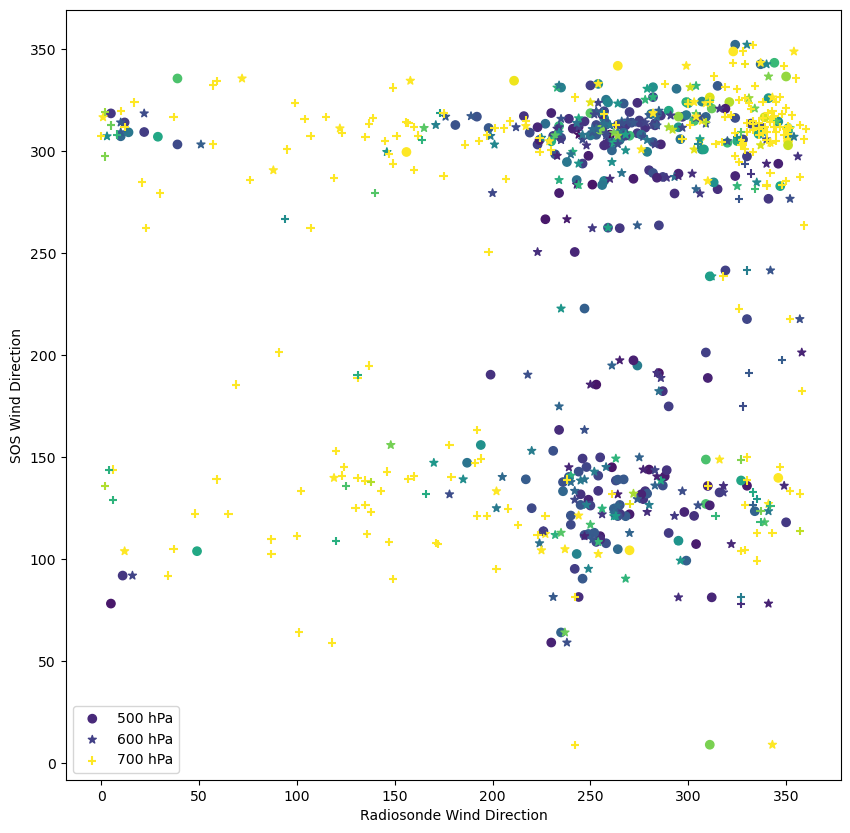

In [66]:


plt.figure(figsize=(10, 10))
plt.scatter(pres_500['deg'], pres_500['dir_10m_c'], c=pres_500['wspd_fraction'], marker='o', label='500 hPa', vmin=0,vmax=0.5)
plt.scatter(pres_600['deg'], pres_600['dir_10m_c'], c=pres_600['wspd_fraction'], marker='*', label='600 hPa', vmin=0,vmax=0.5)
plt.scatter(pres_700['deg'], pres_700['dir_10m_c'], c=pres_700['wspd_fraction'], marker='+', label='700 hPa', vmin=0,vmax=0.5)

plt.legend()

plt.ylabel('SOS Wind Direction')
plt.xlabel('Radiosonde Wind Direction')